### Sample Pre-filtering Notebook  

This notebook contains all the code related to the **Sample Pre-filtering** step of the pipeline. Each cell includes a detailed description of its function.  

#### Key Functions:
1. **Extraction of Klebsiella pneumoniae Test Samples:**  
   - Generates `klebsiella_test_samples_long_table.csv` and `klebsiella_test_embeddings.npy`  
   - Extracts the test samples from the **DRIAMS** dataset, which initially includes multiple species  

2. **Filter 1 - Model-Based Exclusion:**  
   - Predicts resistance probabilities for known (**sample, drug, response**) triplets  
   - Identifies and excludes samples where the model fails to correctly predict the response  

3. **Filter 2 - Multi-Drug Resistance Identification:**  
   - Detects samples that are **known to be resistant** to at least one antibiotic  

4. **PCA Projection of Spectra Embeddings:**  
   - Visualizes test sample embeddings using **2D PCA projections**  
   - Labels samples based on their **dataset of origin** or **filter selection criteria** (included/excluded)  



In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import pandas as pd
import os
import numpy as np
import json
import re
from gv_experiments.models.classifier import Residual_AMR_Classifier

In [2]:
## DATASET CLASSES FOR SAMPLE SPECTRA AND DRUG EMBEDDINGS ## 
    
class SampleEmbDataset(Dataset):
    def __init__(self, long_table, spectra_matrix):
        # Convert the spectra matrix into a PyTorch tensor with floating point values
        self.spectra_tensor = torch.tensor(spectra_matrix).float()

        # Extract unique sample IDs and sort them
        sorted_samples = sorted(long_table["sample_id"].unique())
        
        # Create mappings between sample indices and sample IDs
        self.idx2sample = {i: smp for i, smp in enumerate(sorted_samples)}
        self.sample2idx = {smp: i for i, smp in self.idx2sample.items()}

        # Remove unnecessary columns ("drug" and "response") and drop duplicate rows
        long_table = long_table.drop(["drug", "response"], axis=1)
        long_table = long_table.drop_duplicates()
        self.long_table = long_table

    def __len__(self):
        # Return the number of unique sample entries in the dataset
        return len(self.long_table)

    def __getitem__(self, idx):
        # Retrieve the sample ID for the given index
        sample_id = self.long_table.iloc[idx]["sample_id"]
        
        # Fetch the corresponding spectrum embedding from the tensor
        spectrum_embedding = self.spectra_tensor[self.sample2idx[sample_id], :]
        
        return sample_id, spectrum_embedding



class DrugResistanceDataset_Fingerprints(Dataset):
    def __init__(self, drugs_fingerprints, fingerprint_class):
        """
        Args:
            drugs_fingerprints (pd.DataFrame): DataFrame containing drug fingerprints and names.
            fingerprint_class (str): Type of fingerprint to use.
        """
        # Store drug names for retrieval in the dataset
        self.drug_names = drugs_fingerprints["drug"].tolist()
        
        # Process fingerprints based on the specified fingerprint type
        if fingerprint_class == "all":
            # Concatenate all fingerprint columns except "drug" and "morgan_512_fp"
            fp_series = drugs_fingerprints.drop(["drug", "morgan_512_fp"], axis=1).apply(
                "".join, axis=1
            )
            # Convert fingerprint strings into tensors
            self.drugs_tensor = torch.tensor(
                [[int(v) for v in list(fp)] for fp in fp_series]
            ).float()

        elif fingerprint_class in ["selfies_label", "selfies_flattened_one_hot"]:
            # Parse space-separated fingerprint representations into tensors
            self.drugs_tensor = torch.tensor(
                [
                    [int(v) for v in row[fingerprint_class].split()]
                    for _, row in drugs_fingerprints.iterrows()
                ]
            ).float()

        elif fingerprint_class in ["molformer_huggingFace", "molformer_github"]:
            # Parse comma-separated MolFormer embeddings into tensors
            self.drugs_tensor = torch.tensor(
                [
                    [float(v) for v in row[fingerprint_class].split(",")]
                    for _, row in drugs_fingerprints.iterrows()
                ]
            ).float()

        else:
            # Default case: extract the fingerprint column as a list of binary values
            self.drugs_tensor = torch.tensor(
                [
                    [int(v) for v in list(row[fingerprint_class + "_fp"])]
                    for _, row in drugs_fingerprints.iterrows()
                ]
            ).float()

    def __len__(self):
        # Return the number of drug samples in the dataset
        return len(self.drugs_tensor)

    def __getitem__(self, idx):
        # Retrieve the drug name and its corresponding fingerprint tensor
        return self.drug_names[idx], self.drugs_tensor[idx]
 

## HELPER FUNCTIONS FOR PROCESSING FILES CONTAINING SAMPLE IDS ##

def load_samples(tracking_file):
    """Load processed sample IDs from a tracking file."""
    if os.path.exists(tracking_file):
        with open(tracking_file, 'r') as f:
            return set(f.read().splitlines())
    return set()

def save_sample(tracking_file, sample_id):
    """Append a processed sample ID to the tracking file."""
    with open(tracking_file, 'a') as f:
        f.write(f"{sample_id}\n")

In [ ]:
## EXTRACTS THE SPECTRA EMBEDDINGS FOR KLEBSIELLA TEST SAMPLES AND SAVES THEM IN A .NPY FILE ## 

# Load dataset splits, combined long-table, spectra embeddings
data_split = pd.read_csv("ABCD/data_splits.csv")
long_table = pd.read_csv("ABCD/combined_long_table.csv")
embeddings = np.load("ABCD/rawSpectra_data.npy")

# Remove duplicate entries based on "sample_id" to ensure uniqueness
long_table = long_table.drop_duplicates('sample_id')

# Merge the data split information with the long table based on "sample_id"
merged_data = pd.merge(data_split, long_table, on="sample_id")

# Filter for test samples belonging to Klebsiella pneumoniae
species_test_samples = merged_data[
    (merged_data['Set'] == 'test') &  # Select test set samples
    (merged_data['species'] == 'Klebsiella pneumoniae')  # Select only Klebsiella pneumoniae species
]

# Keep only relevant columns: sample ID, drug name, and response
species_test_samples = species_test_samples[["sample_id", "drug", "response"]]

# Retrieve the indices of the selected test samples
species_indices = species_test_samples.index

# Extract the corresponding spectra embeddings using the selected indices
species_test_embeddings = embeddings[species_indices]

# Save the filtered embeddings as a .npy file for later use
np.save("klebsiella_data/klebsiella_test_embeddings_filtered_raw.npy", species_test_embeddings)


In [ ]:
## CREATES AND SAVES A LONG-TABLE (TABLE CONTAINING KNOWN SAMPLE-DRUG-RESPONSE TRIPLETS) FOR KLEBSIELLA TEST SAMPLES ONLY ##  

import pandas as pd

# Load dataset splits information and combined long-table
data_split = pd.read_csv("ABCD/data_splits.csv")
long_table = pd.read_csv("ABCD/combined_long_table.csv")

# Merge the data split information with the long table based on "sample_id"
merged_data = pd.merge(data_split, long_table, on="sample_id")

# Filter for test samples belonging to Klebsiella pneumoniae
species_test_samples = merged_data[
    (merged_data['Set'] == 'test') &  # Select test set samples
    (merged_data['species'] == 'Klebsiella pneumoniae')  # Select only Klebsiella pneumoniae species
]

# Keep only relevant columns: sample ID, drug name, and response
species_test_samples = species_test_samples[["sample_id", "drug", "response"]]

# Save the filtered test samples as a CSV file for later use
species_test_samples.to_csv("klebsiella_data/klebsiella_test_samples_long_table.csv", index=False)


In [ ]:
## CREATES AND SAVES A TABLE CONTAINING IDS AND DATASETS OF THE KLEBSIELLA PNEUMONIAE TEST SAMPLES ##

import pandas as pd

# Define the file path to the long table file containing the datasets to where the samples belong
file_path = "../MultimodalAMR-main-updated/ABCD/DRIAMS_5folds_trainTestVal.csv"  
df = pd.read_csv(file_path)

# Filter the DataFrame to include only test samples of Klebsiella pneumoniae
filtered_df = df[(df["species"] == "Klebsiella pneumoniae") & (df["Set"] == "test")]

# Remove duplicate entries based on "sample_id" to ensure unique samples
unique_samples = filtered_df.drop_duplicates(subset=["sample_id"])

# Select only the relevant columns: sample ID and dataset year
final_df = unique_samples[["sample_id", "dataset_year"]]

# Save the filtered test sample information as a CSV file for later use
final_df.to_csv("klebsiella_data/klebsiella_test_sample_ids_and_datasets.csv", index=False)


In [3]:
## SETS UP THE 2 DATALOADERS NEEDED: ONE FOR THE KLEBSIELLA TEST SAMPLES AND ONE FOR THE ANTIBIOTICS ##

spectra_input = "MAE" # raw or MAE
drug_emb_type = "molformer_github" # molformer_github or morgan_1024

# Load the preprocessed spectra embeddings for Klebsiella pneumoniae test samples
spectra_matrix = np.load(f'klebsiella_data/klebsiella_test_embeddings_filtered_{spectra_input}.npy')

# Load the drug fingerprints of the known antibiotics
drug_file_path = 'ABCD/drug_fingerprints_Mol_selfies.csv' 
drugs_df = pd.read_csv(drug_file_path)

# Load the long-table containing Klebsiella pneumoniae test sample-drug-response triplets
long_table = pd.read_csv("klebsiella_data/klebsiella_test_samples_long_table.csv")

# Initialize the dataset for drug fingerprints using Morgan 1024-bit fingerprints or 768-dim Molformer encodings 
drug_dataset = DrugResistanceDataset_Fingerprints(drugs_fingerprints=drugs_df, fingerprint_class=drug_emb_type)

# Initialize the dataset for Klebsiella pneumoniae test samples with their spectra embeddings
species_dataset = SampleEmbDataset(long_table, spectra_matrix)

# Create a DataLoader for the species dataset (batch size 1, no shuffling for test samples)
species_loader = DataLoader(species_dataset, batch_size=1, shuffle=False)

# Create a DataLoader for the drug dataset (batch size 16, no shuffling for evaluation)
drug_dataloader = DataLoader(drug_dataset, batch_size=16, shuffle=False)

print("Data loaders set")


Data loaders set


In [4]:
## LOADS THE ResMLP MODEL FOR INFERENCE ##  

import json

input_type = "mae_molformer"

if input_type == "raw_morgan":
    config_path= "ABCD/ResultsAndCheckpoints/ABCD/raw_fing/new_loader_rawMS_fing_ABCD_DRIAMS-any_specific/config.json"
    checkpoint_path = ".ABCD/ResultsAndCheckpoints/ABCD/raw_fing/new_loader_rawMS_fing_ABCD_DRIAMS-any_specific/0/lightning_logs/version_0/checkpoints/epoch=99-step=394700.ckpt"

elif input_type == "mae_molformer":
    config_path = "ABCD/ResultsAndCheckpoints/ABCD/MAE_Mol/new_loader_MAE_Mol_ABCD_DRIAMS-any_specific/config.json"
    checkpoint_path = "ABCD/ResultsAndCheckpoints/ABCD/MAE_Mol/new_loader_MAE_Mol_ABCD_DRIAMS-any_specific/0/lightning_logs/version_0/checkpoints/epoch=99-step=394700.ckpt"

else: print("Invalid input type")

with open(config_path, 'r') as f:
    config = json.load(f)

checkpoint = torch.load(checkpoint_path, weights_only=True, map_location="mps")

state_dict = {key.replace("model.", ""): value for key, value in checkpoint['state_dict'].items()}

model = Residual_AMR_Classifier(config)
model.load_state_dict(state_dict)
model.eval()

print("Model loaded, initiating inference")

Model loaded, initiating inference


In [5]:
## FOR EACH ONE OF THE KLEBSIELLA TEST SAMPLES, A .CSV FILE IS SAVED IN THE output_file FOLDER WITH THE MODEL'S PREDICTIONS ON KNOWN ANTIBIOTICS ##

input_type = "mae_molformer"

# Path to the tracking file that records already processed samples
tracking_file = f"prefiltering_{input_type}/processed_samples.txt"

# Load the list of samples that have already been processed
processed_samples = load_samples(tracking_file)

# Iterate through each test sample in the species data loader
for sample_id, spectrum_embedding in species_loader:
    sample_id_str = str(sample_id[0])  # Convert sample ID to string

    # Skip processing if the sample was already processed
    if sample_id_str in processed_samples:
        print(f"Sample {sample_id_str} already processed. Skipping.")
        continue

    # Prepare the spectrum embedding by removing unnecessary dimensions
    spectrum_embedding = spectrum_embedding.squeeze(0)

    # Initialize lists to store predictions and corresponding drug names
    predictions = []
    drug_names_col = []

    # Iterate through drug batches from the drug data loader
    for drug_names, embeddings in drug_dataloader:
        batch_size = embeddings.size(0)  # Get the batch size

        # Expand the spectrum embedding to match the batch size
        spectrum_batch = spectrum_embedding.expand(batch_size, -1)

        # Create a tensor filled with the species index (assumed to be 172 for Klebsiella pneumoniae)
        species_idx = torch.full((batch_size,), 172, dtype=torch.float32)

        # Pass the inputs through the model to obtain predictions
        outputs = model(
            species_idx=species_idx,
            x_spectrum=spectrum_batch,
            dr_tensor=embeddings
        )

        # Apply the sigmoid function to obtain probability scores
        probabilities = torch.sigmoid(outputs)
        probabilities = probabilities.view(-1)  # Flatten the output

        # Store the predictions and corresponding drug names
        predictions.extend(probabilities.detach().cpu().numpy().tolist())
        drug_names_list = [name for name in drug_names]
        drug_names_col.extend(drug_names_list)

    # Create a DataFrame with drug names and corresponding predictions
    predictions_df = pd.DataFrame({
        'Drugs': drug_names_col,
        'Predictions': predictions
    })

    # Define the output file path for saving predictions
    output_file = f"prefiltering_{input_type}/predictions_sample_{sample_id_str}.csv"
    
    # Save the predictions to a CSV file
    predictions_df.to_csv(output_file, index=False)

    print(f"Saved predictions for sample {sample_id_str} to {output_file}")

    # Mark the sample as processed by saving it in the tracking file
    save_sample(tracking_file, sample_id_str)

print("Inference completed")



Saved predictions for sample 007893a6-6ff9-4fe9-9b4b-d65fb4f181ca_MALDI2 to prefiltering_mae_molformer/predictions_sample_007893a6-6ff9-4fe9-9b4b-d65fb4f181ca_MALDI2.csv
Saved predictions for sample 00b8b1c1-1a90-42df-90cb-63388b4ca1c0_MALDI2 to prefiltering_mae_molformer/predictions_sample_00b8b1c1-1a90-42df-90cb-63388b4ca1c0_MALDI2.csv
Saved predictions for sample 02ad184c-5b89-4a88-9713-57f22524868a_3313 to prefiltering_mae_molformer/predictions_sample_02ad184c-5b89-4a88-9713-57f22524868a_3313.csv
Saved predictions for sample 032d7989-c976-4c24-b809-48d80c4f1571_MALDI2 to prefiltering_mae_molformer/predictions_sample_032d7989-c976-4c24-b809-48d80c4f1571_MALDI2.csv
Saved predictions for sample 03c5aaad-64e3-4f0b-9bbf-c16f5766cc01_3312 to prefiltering_mae_molformer/predictions_sample_03c5aaad-64e3-4f0b-9bbf-c16f5766cc01_3312.csv
Saved predictions for sample 04799d35-3076-4565-967c-d770b0f935e3 to prefiltering_mae_molformer/predictions_sample_04799d35-3076-4565-967c-d770b0f935e3.csv
Sa

In [6]:
## COMPARES THE MODEL'S PREDICTIONS ON KNOWN ANTIBIOTICS WITH THE TARGET RESPONSES SAVES THE SAMPLE IDS OF SAMPLES WHERE THE MODEL MAKES EVEN ONE WRONG ESTIMATION 
## IN THE output_file_path .TXT FILE ##  

import re
import os
import pandas as pd

input_type = "mae_molformer"

# Define file paths
predictions_folder = f"prefiltering_{input_type}"
known_triplets_path = "klebsiella_data/klebsiella_test_samples_long_table.csv"
output_file_path = f"sample_lists/excluded_samples_{input_type}.txt"

# Load the known sample-drug-response triplets
known_triplets = pd.read_csv(known_triplets_path)

# Convert response values to integers for comparison
known_triplets['response'] = known_triplets['response'].astype(int)

# Open the output file to store sample IDs where incorrect predictions occur
with open(output_file_path, 'w') as output_file:
    # Iterate over all prediction files in the specified folder
    for filename in os.listdir(predictions_folder):
        # Ensure the file matches the expected naming pattern for sample predictions
        if filename.startswith("predictions_sample_") and filename.endswith(".csv"):
            match = re.match(r"predictions_sample_(.+)\.csv", filename)
            if match:
                sample_id = match.group(1)  # Extract the sample ID from the filename
            else:
                print(f"Filename {filename} does not match the expected pattern.")
                continue

            # Load the model's predictions for this sample
            predictions_path = os.path.join(predictions_folder, filename)
            predictions = pd.read_csv(predictions_path)

            # Retrieve the known response triplets for this sample
            sample_triplets = known_triplets[known_triplets['sample_id'].str.contains(sample_id)]

            # Skip processing if no matching sample data is found
            if sample_triplets.empty:
                continue

            # Merge known triplets with predictions based on the drug name
            merged = sample_triplets.merge(
                predictions,
                left_on="drug",
                right_on="Drugs",
                how="inner"
            )

            # Convert predicted probabilities into binary classifications (threshold: 0.5)
            merged['predicted_response'] = (merged['Predictions'] >= 0.5).astype(int)

            # Check if the predicted response matches the actual response
            merged['is_correct'] = merged['predicted_response'] == merged['response']

            # If there is at least one incorrect prediction, save the sample ID
            if not merged['is_correct'].all():
                output_file.write(f"{sample_id}\n")

print(f"Finished checking predictions. Incorrect samples are saved in: {output_file_path}")



Finished checking predictions. Incorrect samples are saved in: sample_lists/excluded_samples_mae_molformer.txt


In [ ]:
## MULTI-DRUG SAMPLE IDENTIFICATION: SAVES THE MDR (MULTI-DRUG RESISTANT) SAMPLES IN THE output_file .TXT FILE FOR A GIVEN threshold SPECIFYING THE NUMBER OF DRUGS 
## A SAMPLE MUST BE RESISTANT TO ##

import pandas as pd

# Load the Klebsiella pneumoniae test samples long-table, which contains sample-drug-response triplets
data = pd.read_csv("../MultimodalAMR-main-updated/klebsiella_data/klebsiella_test_samples_long_table.csv")  

# Define the threshold for multi-drug resistance (MDR)
threshold = 2  # A sample must be resistant to at least this many drugs to be considered MDR

# Filter for resistant responses (response == 1), then group by sample ID and retain those meeting the threshold
multi_resistant_samples = (
    data[data["response"] == 1]  # Select only resistant cases
    .groupby("sample_id")  # Group by sample ID
    .filter(lambda x: len(x) >= threshold)  # Keep only samples with resistance to at least 'threshold' drugs
)

# Extract the unique sample IDs of MDR samples
multi_resistant_sample_ids = multi_resistant_samples["sample_id"].unique()

# Define the output file path, dynamically adjusting to the threshold value
output_file = f"../MultimodalAMR-main-updated/sample_lists/multi_resistant_samples_threshold={threshold}.txt"

# Save the MDR sample IDs to a text file, one per line
with open(output_file, "w") as f:
    for sample_id in multi_resistant_sample_ids:
        f.write(sample_id + "\n")

print(f"Multi-resistant samples were saved to {output_file}")



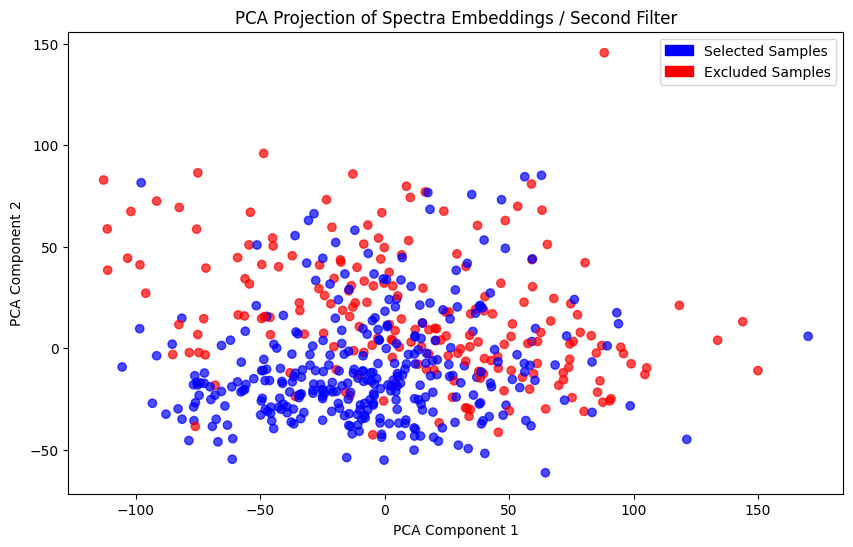

In [ ]:
## PLOTS 2D PCA PROJECTIONS OF THE KLEBSIELLA TEST SAMPLE SPECTRA LABELS THEM EITHER ACCORDING TO THEIR DATASET OF ORIGIN OR THEIR SELECTION FROM A FILTER ##

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from torch.utils.data import Dataset


### ---- DATA LOADER CLASS ---- ###  
# Similar to the previous definition but includes dataset_year for additional labeling
class SampleEmbDataset(Dataset):
    def __init__(self, long_table, spectra_matrix):
        # Convert the spectra matrix into a PyTorch tensor
        self.spectra_tensor = torch.tensor(spectra_matrix).float()

        # Create mappings for sample IDs
        sorted_samples = sorted(long_table["sample_id"].unique())
        self.idx2sample = {i: smp for i, smp in enumerate(sorted_samples)}
        self.sample2idx = {smp: i for i, smp in self.idx2sample.items()}

        # Remove duplicate entries
        self.long_table = long_table.drop_duplicates()

    def __len__(self):
        return len(self.long_table)

    def __getitem__(self, idx):
        # Retrieve sample details for the given index
        sample_id = self.long_table.iloc[idx]["sample_id"]
        dataset_year = self.long_table.iloc[idx]["dataset_year"]
        spectrum_embedding = self.spectra_tensor[self.sample2idx[sample_id], :]
        return sample_id, dataset_year, spectrum_embedding


### HELPER FUNCTION: LOAD SAMPLE LIST FROM TXT ###
def load_sample_list(file_path):
    """Loads a set of sample IDs from a text file."""
    with open(file_path, "r") as f:
        return {line.strip() for line in f}


### PCA PROJECTION & PLOTTING FUNCTIONS ###
def plot_pca_projection_filters(dataset, mdr_samples, excluded_samples, filter, save_path=None):
    """
    Performs PCA and plots embeddings based on selected filter criteria:
    - Selected samples -> Blue.
    - Excluded samples -> Red.

    Args:
        dataset: Dataset containing sample embeddings and metadata.
        mdr_samples: Set of multi-drug resistant sample IDs.
        excluded_samples: Set of sample IDs where at least one incorrect prediction was made.
        filter: Choice of filter ("First Filter", "Second Filter", or "Both Filters").
        save_path: Optional path to save the plot. If None, the plot is displayed.
    """
    # Extract sample embeddings & names
    sample_ids = []
    spectra_embeddings = []

    for sample_id, _, spectrum_embedding in dataset:
        sample_ids.append(sample_id)
        spectra_embeddings.append(spectrum_embedding.numpy())

    spectra_embeddings = np.stack(spectra_embeddings)

    # Perform PCA to reduce dimensionality to 2D
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(spectra_embeddings)

    # Define color mapping based on the selected filter
    if filter == "Both Filters":
        colors = ["blue" if sample in mdr_samples and sample not in excluded_samples else "red" for sample in sample_ids]
    
    elif filter == "First Filter":
        colors = ["red" if sample in excluded_samples else "blue" for sample in sample_ids]
    
    elif filter == "Second Filter":
        colors = ["blue" if sample in mdr_samples else "red" for sample in sample_ids]

    else:
        print("Invalid filter string")
        return

    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=colors, alpha=0.7)

    # Define legend for the color coding
    red_patch = mpatches.Patch(color="blue", label="Selected Samples")
    black_patch = mpatches.Patch(color="red", label="Excluded Samples")
    plt.legend(handles=[red_patch, black_patch])

    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(f"PCA Projection of Spectra Embeddings / {filter}")

    # Save or display the plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Saved PCA plot to {save_path}")
    else:
        plt.show()


def plot_pca_projection_datasets(dataset, save_path=None):
    """
    Performs PCA and plots embeddings, coloring samples based on their dataset of origin.

    Args:
        dataset: Dataset containing sample embeddings and dataset year metadata.
        save_path: Optional path to save the plot. If None, the plot is displayed.
    """
    # Extract sample embeddings & dataset years
    sample_ids = []
    spectra_embeddings = []
    dataset_years = []

    for sample_id, dataset_year, spectrum_embedding in dataset:
        sample_ids.append(sample_id)
        dataset_years.append(dataset_year)
        spectra_embeddings.append(spectrum_embedding.numpy())

    spectra_embeddings = np.array(spectra_embeddings)

    # Perform PCA to reduce dimensionality to 2D
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(spectra_embeddings)

    # Define unique dataset years and assign a distinct color to each
    unique_years = sorted(set(dataset_years))
    colors = plt.cm.get_cmap("tab10", len(unique_years))
    year_color_map = {year: colors(i) for i, year in enumerate(unique_years)}

    # Create scatter plot with colors assigned to each dataset year
    plt.figure(figsize=(10, 7))
    for i, year in enumerate(dataset_years):
        plt.scatter(
            reduced_embeddings[i, 0],
            reduced_embeddings[i, 1],
            color=year_color_map[year],
            label=year if year not in dataset_years[:i] else ""  # Avoid duplicate labels
        )

    # Create legend
    legend_patches = [mpatches.Patch(color=year_color_map[year], label=year) for year in unique_years]
    plt.legend(handles=legend_patches, title="Dataset Year")
    
    # Set axis labels and title
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title("PCA Projection of Spectra Embeddings")

    # Save or display the plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Saved PCA plot to {save_path}")
    else:
        plt.show()


# Load data #
input_type= "mae_molformer" 
spectra_type = "mae"

spectra_matrix = np.load(f'klebsiella_data/klebsiella_test_embeddings_filtered_{spectra_type}.npy') 
long_table = pd.read_csv("klebsiella_data/klebsiella_test_sample_ids_and_datasets.csv")

# Initialize dataset
dataset = SampleEmbDataset(long_table, spectra_matrix)

# Load sample lists 
mdr_samples_file = "../MultimodalAMR-main-updated/sample_lists/multi_resistant_samples_threshold=1.txt"  
excluded_samples_file = f"../MultimodalAMR-main-updated/sample_lists/excluded_samples_{input_type}.txt"

mdr_samples = load_sample_list(mdr_samples_file)
excluded_samples = load_sample_list(excluded_samples_file)

# Choose plot type 
plot = "filter"  # "filter" or "dataset"

# Run PCA and plot based on the selected type
if plot == "filter":
    plot_pca_projection_filters(dataset, mdr_samples, excluded_samples, filter="Second Filter")  
    # Available filters: "First Filter", "Second Filter", or "Both Filters"

elif plot == "dataset":
    plot_pca_projection_datasets(dataset)

